# Unzipping dataset

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FYP2/dataset.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

# Installing Detectron2

Importing necessary libraies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-advab10s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-advab10s
  Resolved https://github.com/facebookresearch/detectron2.git to commit e9f7e2ba15abd7badcb05ef6f5076f06b36a9c5b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6122101 sha256=9aece600a8aff5d0d48af1bccbdf6

In [ ]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (you can remove unnecessary imports)

import torch, torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import cv2
import numpy as np
import IPython
import json
import os
import json
import csv
import time
#import random
from pathlib import Path

# Data Preparation

Creating data pairs and converting YOLO formatted annotation files to COCO format.

In [ ]:
def create_data_pairs(input_path, detectron_img_path, detectron_annot_path, dir_type = 'train'):

    img_paths = Path(input_path + dir_type + '/images/').glob('*.jpg')
    pairs = []
    for img_path in img_paths:

        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))

        label_path = Path(input_path + dir_type + '/labels/' + file_name + '.txt')

        if label_path.is_file():

            line_img = detectron_img_path + dir_type+'/images/'+ file_name + '.jpg'
            line_annot = detectron_annot_path+dir_type+'/labels/' + file_name + '.txt'
            pairs.append([line_img, line_annot])

    return pairs

In [ ]:
input_path = './dataset/'

detectron_img_path = './dataset/'
detectron_annot_path = './dataset/'

In [ ]:
train = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'train')
val = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'valid')

In [ ]:
print(train)

[['./dataset/train/images/BW-263_jpg.rf.4392f6343bc9d190dc86656582888668.jpg', './dataset/train/labels/BW-263_jpg.rf.4392f6343bc9d190dc86656582888668.txt'], ['./dataset/train/images/BW-358_jpg.rf.2c66f4ccd0305c85e2663f85f3bdff1c.jpg', './dataset/train/labels/BW-358_jpg.rf.2c66f4ccd0305c85e2663f85f3bdff1c.txt'], ['./dataset/train/images/BW-63_jpg.rf.e71aa6970ea40721dc5b4bfc2336c23e.jpg', './dataset/train/labels/BW-63_jpg.rf.e71aa6970ea40721dc5b4bfc2336c23e.txt'], ['./dataset/train/images/BW-344_jpg.rf.330ccef9cc30b18446a038c0ad2d1ff6.jpg', './dataset/train/labels/BW-344_jpg.rf.330ccef9cc30b18446a038c0ad2d1ff6.txt'], ['./dataset/train/images/BW-357_jpg.rf.e1852a71fe27cdc8e952627b5d377a85.jpg', './dataset/train/labels/BW-357_jpg.rf.e1852a71fe27cdc8e952627b5d377a85.txt'], ['./dataset/train/images/BW-293_jpg.rf.1f106b5a73895f69d2476d37114ba24d.jpg', './dataset/train/labels/BW-293_jpg.rf.1f106b5a73895f69d2476d37114ba24d.txt'], ['./dataset/train/images/BW-356_jpg.rf.47fb92bbb8a243a4e462ddc836

In [ ]:
def create_coco_format(data_pairs):

    data_list = []

    for i, path in enumerate(data_pairs):

        filename = path[0]

        img_h, img_w = cv2.imread(filename).shape[:2]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        print(str(i), filename)


        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0
                }
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list

In [ ]:
train_list = create_coco_format(train)
val_list = create_coco_format(val)

0 ./dataset/train/images/BW-263_jpg.rf.4392f6343bc9d190dc86656582888668.jpg
1 ./dataset/train/images/BW-358_jpg.rf.2c66f4ccd0305c85e2663f85f3bdff1c.jpg
2 ./dataset/train/images/BW-63_jpg.rf.e71aa6970ea40721dc5b4bfc2336c23e.jpg
3 ./dataset/train/images/BW-344_jpg.rf.330ccef9cc30b18446a038c0ad2d1ff6.jpg
4 ./dataset/train/images/BW-357_jpg.rf.e1852a71fe27cdc8e952627b5d377a85.jpg
5 ./dataset/train/images/BW-293_jpg.rf.1f106b5a73895f69d2476d37114ba24d.jpg
6 ./dataset/train/images/BW-356_jpg.rf.47fb92bbb8a243a4e462ddc83632ec8a.jpg
7 ./dataset/train/images/BW-276_jpg.rf.56138596e94de9c68b8a5600a3a4b9e6.jpg
8 ./dataset/train/images/BW-304_jpg.rf.be5c88cec9099eaa0e3068ca3ce0679c.jpg
9 ./dataset/train/images/BW-393_jpg.rf.f7ad9df45a52fa358b15712a0323a755.jpg
10 ./dataset/train/images/BW-379_jpg.rf.5c8cf1f4cdba6637cafee31ba6b0634a.jpg
11 ./dataset/train/images/BW-188_jpg.rf.22fcfbc9e3ccef0d65dd1351fe16c050.jpg
12 ./dataset/train/images/BW-301_jpg.rf.1087c3ddaf9dfa1e542d84198ab525da.jpg
13 ./datas

In [ ]:
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['dentin caries','enamel caries'])

In [ ]:
metadata = MetadataCatalog.get("train")

In [ ]:
MetadataCatalog.get("val")

namespace(name='val', thing_classes=['dentin caries', 'enamel caries'])

In [ ]:
max_iter = 10000
print(max_iter)
print(len(train_list))

10000
321


# Detectron2: Faster R-CNN R50 FPN Configuration

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = max_iter # (train_size / batch_size) * 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("train").thing_classes)
cfg.SOLVER.STEPS = (20500, )

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

import time as t
s1 = t.time()
try:
  trainer.train()
except:
  None
s2 = t.time()
print(s2-s1)

[01/08 22:35:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 92.2MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/08 22:35:12 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/08 22:35:27 d2.utils.events]:  eta: 1:19:58  iter: 19  total_loss: 1.522  loss_cls: 1.103  loss_box_reg: 0.000826  loss_rpn_cls: 0.3813  loss_rpn_loc: 0.02774    time: 0.5076  last_time: 0.4140  data_time: 0.0924  last_data_time: 0.0608   lr: 1.9981e-05  max_mem: 3064M
[01/08 22:35:43 d2.utils.events]:  eta: 1:11:33  iter: 39  total_loss: 1.094  loss_cls: 0.6027  loss_box_reg: 0.0006807  loss_rpn_cls: 0.3654  loss_rpn_loc: 0.02968    time: 0.4622  last_time: 0.2334  data_time: 0.0572  last_data_time: 0.0288   lr: 3.9961e-05  max_mem: 3065M
[01/08 22:35:48 d2.utils.events]:  eta: 0:56:25  iter: 59  total_loss: 0.5915  loss_cls: 0.2204  loss_box_reg: 0.0122  loss_rpn_cls: 0.244  loss_rpn_loc: 0.02721    time: 0.3882  last_time: 0.2453  data_time: 0.0230  last_data_time: 0.0263   lr: 5.9941e-05  max_mem: 3065M
[01/08 22:35:53 d2.utils.events]:  eta: 0:47:29  iter: 79  total_loss: 0.2853  loss_cls: 0.1018  loss_box_reg: 0.01906  loss_rpn_cls: 0.1446  loss_rpn_loc: 0.02004    time: 0.35

# Inference Example

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

[01/08 23:21:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


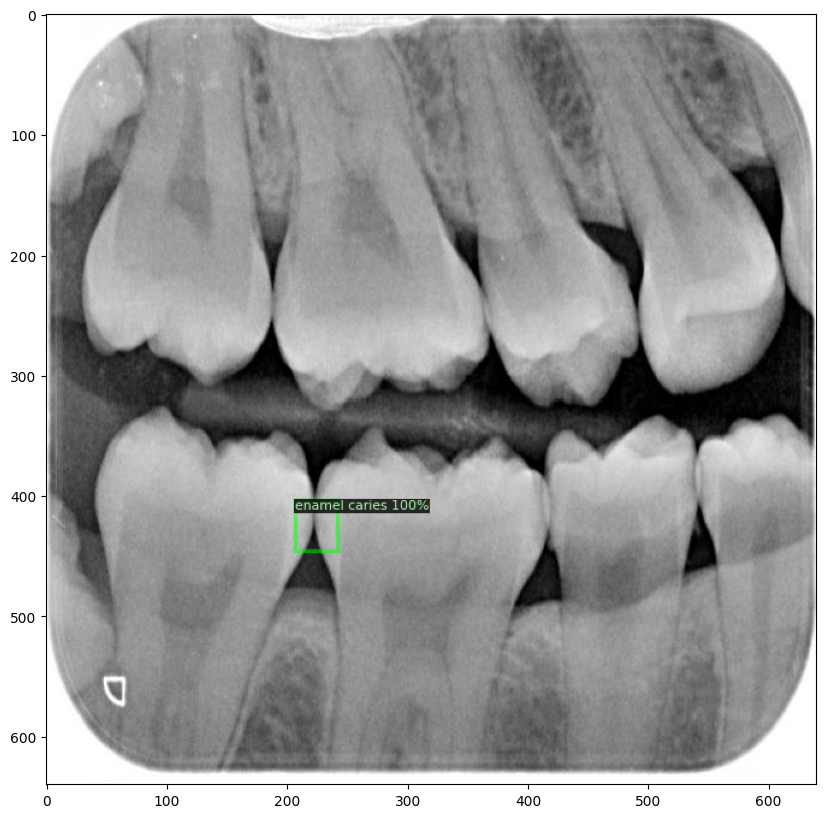

In [ ]:
im = cv2.imread("/content/dataset/test/images/BW-161_jpg.rf.0b99afc06ee5d111f95d52d839c2de26.jpg")
outputs = predictor(im)
v = Visualizer(im, metadata=metadata, scale=1., instance_mode =  ColorMode.IMAGE)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)

# Evaluation

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[01/08 23:21:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


WARNING [01/08 23:21:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/08 23:21:18 d2.evaluation.coco_evaluation]: Trying to convert 'val' to COCO format ...
[01/08 23:21:18 d2.data.datasets.coco]: Converting annotations of dataset 'val' to COCO format ...)
[01/08 23:21:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/08 23:21:18 d2.data.datasets.coco]: Conversion finished, #images: 30, #annotations: 66
[01/08 23:21:18 d2.data.datasets.coco]: Caching COCO format annotations at './output/val_coco_format.json' ...
[01/08 23:21:18 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|
| dentin caries | 36           | enamel caries | 30           |
|               |              |               |              |
|     total     |

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[01/08 23:21:19 d2.evaluation.evaluator]: Inference done 11/30. Dataloading: 0.0017 s/iter. Inference: 0.0361 s/iter. Eval: 0.0003 s/iter. Total: 0.0381 s/iter. ETA=0:00:00
[01/08 23:21:20 d2.evaluation.evaluator]: Total inference time: 0:00:00.996771 (0.039871 s / iter per device, on 1 devices)
[01/08 23:21:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.034362 s / iter per device, on 1 devices)
[01/08 23:21:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/08 23:21:20 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/08 23:21:20 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/08 23:21:20 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/08 23:21:20 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[01/08 23:21:20 d2.evaluation.

OrderedDict([('bbox',
              {'AP': 15.514576702732874,
               'AP50': 42.35555915230723,
               'AP75': 4.247460460331748,
               'APs': 13.550766275297283,
               'APm': 19.05727265202842,
               'APl': 0.0,
               'AP-dentin caries': 21.039296501223287,
               'AP-enamel caries': 9.989856904242462})])